# Dependencies

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, precision_score, accuracy_score, recall_score

import pickle

# Import model

In [2]:
# Importing components for siRNA complexation classification model
# classifier
clf = pickle.load(open('Data_files/siRNA_complexation_classifier.pkl', 'rb'))
# descriptor scaler
scaler = pickle.load(open('Data_files/siRNA_complexation_classifier_scaler.pkl', 'rb'))
# complete set of 5666 descriptors
descriptors = pickle.load(open('Data_files/siRNA_complexation_classifier_descriptors_all.pkl', 'rb'))
# 5 descriptors used in random forest classifier
desc_sel = pickle.load(open('Data_files/siRNA_complexation_classifier_descriptors_model.pkl', 'rb'))

# Function defining classification

In [3]:
# Function to perform prediction
def predict_siRNA_complexation(data_input,name):
    #print(data_input)
    data_output = pd.Series(dtype=str)
    data_output['Name'] = name
    if (data_input['ALOGP'] > 8):
        data_output['Prediction'] = True
        data_output['Comment'] =  'ALOGP > 8.0 - Predicted to complex siRNA'
    elif (data_input['nAB'] <= 12):
        data_output['Prediction'] = False
        data_output['Comment'] = 'ALOGP < 8.0 & nAB <= 12 - Predicted NOT to complex siRNA'
    else:
        data_input['NOArRing'] =  (
        (data_input['nArOR']>0)|
        (data_input['nArOH']>0)|
        (data_input['nArOCN']>0)|
        (data_input['nArNCO']>0)|
        (data_input['nArNCS']>0)|
        (data_input['nArOCON']>0)|
        (data_input['nArNHO']>0)|
        (data_input['nArNNOx']>0)|
        (data_input['nArNO']>0)|
        (data_input['nArNO2']>0)|
        (data_input['nArOX']>0)|
        (data_input['nFuranes']>0)|
        (data_input['nOxazoles']>0)|
        (data_input['nIsoxazoles']>0)|
        (data_input['nArNH2']>0) |
        (data_input['nArNHR']>0) |
        (data_input['nArNR2']>0) |
        (data_input['nPyrroles']>0) |
        (data_input['nPyrazoles']>0) |
        (data_input['nImidazoles']>0) |
        (data_input['nThiazoles']>0) |
        (data_input['nIsothiazoles']>0) |
        (data_input['nTriazoles']>0) |
        (data_input['nPyridines']>0) |
        (data_input['nPyridazines']>0) |
        (data_input['nPyrimidines']>0) |
        (data_input['nPyrazines']>0) |
        (data_input['n135-Triazines']>0) |
        (data_input['n124-Triazines']>0)
        )
        if data_input['NOArRing'] == 0:
            data_output['Prediction'] = False
            data_output['Comment'] = 'ALOGP < 8.0 & nAB > 12 but NOArRing = 0 - Predicted NOT to complex siRNA'
        else:
            #if to_scale == True:
            data_input[descriptors] = scaler.transform(data_input[descriptors].to_frame().T).reshape(-1)
            data_output['Prediction'] = clf.predict(data_input[desc_sel].to_frame().T)[0]
            data_output['Comment'] = 'ALOGP < 8.0 & nAB > 12 & NOArRing > 0 - Classification model prediction of: '+str(data_output['Prediction'])
    
    return data_output

# Applying model to all screening data

In [4]:
data_aug = pd.read_csv('Data_files/data_aug.csv')
data_aug_out = data_aug.apply(lambda x: predict_siRNA_complexation(x,x['NAME']),axis=1)
data_aug_out

,Name,Prediction,Comment
0,Reserpine,False,ALOGP < 8.0 & nAB > 12 & NOArRing > 0 - Classi...
1,Azithromycin,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...
2,Ticlopidine,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...
3,Citalopram,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...
4,Nelfinavir,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...
...,...,...,...
197,7h,True,ALOGP > 8.0 - Predicted to complex siRNA
198,7i,True,ALOGP > 8.0 - Predicted to complex siRNA
199,7j,True,ALOGP > 8.0 - Predicted to complex siRNA
200,7k,True,ALOGP > 8.0 - Predicted to complex siRNA


In [5]:
data_aug = data_aug.merge(data_aug_out,left_on='NAME',right_on='Name')

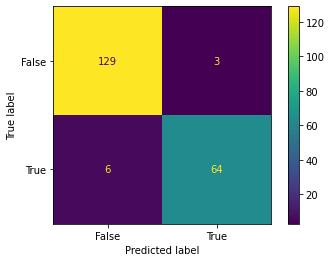

In [6]:
# generate preductions and confusion matrix for train set
cm = confusion_matrix(data_aug['RG_binary'], data_aug['Prediction'], labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

# Applying model to example test drugs

In [7]:
# Input file with molecular desecriptors
example_drugs = pd.read_csv('Data_files/descriptors_example_cases.csv')

# Applying function defining classification model
example_drugs_out = example_drugs.apply(lambda x: predict_siRNA_complexation(x,x['NAME']),axis=1)
example_drugs_out

,Name,Prediction,Comment
0,Emetine analog,True,ALOGP > 8.0 - Predicted to complex siRNA
1,Netarsudil,True,ALOGP < 8.0 & nAB > 12 & NOArRing > 0 - Classi...
2,Sorafenib analogue,True,ALOGP < 8.0 & nAB > 12 & NOArRing > 0 - Classi...


In [8]:
# Examining additional parameters relevant for encapsulation and size of IDNPs
example_drugs[['NAME','CMC-80','ALOGP','AMR','nAB','ChiralCenter','nHDon','JGI7','J_G']]

,NAME,CMC-80,ALOGP,AMR,nAB,ChiralCenter,nHDon,JGI7,J_G
0,Emetine analog,0,13.210,229.0,12,4,0,0.01211,2.367
1,Netarsudil,0,3.901,132.4,23,1,3,0.01011,1.835
2,Sorafenib analogue,0,3.938,127.9,23,0,4,0.00803,1.461


# Applying model to drugs in DrugBank

In [9]:
db_molecules = pd.read_csv('Data_files/descriptors_db_filt.csv',low_memory=False)

# remove descriptors with NA values or where error occured
db_molecules = db_molecules.dropna()
db_molecules = db_molecules[db_molecules['ERROR']=='-']
db_molecules[descriptors] = db_molecules[descriptors].apply(pd.to_numeric,axis=0)

In [10]:
db_molecules_out = db_molecules.apply(lambda x: predict_siRNA_complexation(x,x['NAME']),axis=1)
db_molecules_out

,Name,Prediction,Comment
0,INDECAINIDE,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...
1,reserpine,False,ALOGP < 8.0 & nAB > 12 & NOArRing > 0 - Classi...
2,Azithromycin,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...
3,Ticlopidine,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...
4,Citalopram,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...
...,...,...,...
1581,BP-14979,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...
1582,Revaprazan,False,ALOGP < 8.0 & nAB > 12 & NOArRing > 0 - Classi...
1583,Vicagrel,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...
1584,Volinanserin,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...


In [11]:
sum(db_molecules_out['Prediction'])

363

# Applying model to drugs that were excluded due to anomalous screening results

In [12]:
set1_all = pd.read_csv('Data_files/all_data_from_screening_set_1.csv')
all_results_1 = set1_all[['name','SMILES']]
all_results_1['RG_binary'] = (set1_all['RG'] < 0.5)

set2_all = pd.read_csv('Data_files/all_data_from_screening_set_2.csv')
all_results_2 = set2_all[['name','SMILES']]
all_results_2['RG_binary'] = (set2_all["('All', 'RG_mean')"] < 0.5)

all_results = pd.concat([all_results_1,all_results_2])
all_results = all_results.append({'name':'Abemaciclib',
                                  'SMILES':'CCN1CCN(CC2=CC=C(NC3=NC=C(F)C(=N3)C4=CC(F)=C5N=C(C)N(C(C)C)C5=C4)N=C2)CC1',
                                  'RG_binary':True}, 
                                 ignore_index=True)
all_results = all_results.append({'name':'AMG-208',
                                  'SMILES':'COC1=CC2=NC=CC(OCC3=NN=C4C=CC(=NN34)C5=CC=CC=C5)=C2C=C1',
                                  'RG_binary':True}, 
                                 ignore_index=True)
db_filt = pd.read_csv('Data_files/db_filt.csv')
db_molecules = db_filt[['name','drugbank_id']].merge(db_molecules,on='drugbank_id')
db_tested = db_molecules.merge(all_results,on='name')
set1_filt = pd.read_csv('Data_files/RG_for_ML.csv')
set2_filt = pd.read_csv('Data_files/RG_for_ML_2.csv')
excluded_drugs = db_tested[(~db_tested['name'].isin(set1_filt['NAME']))&(~db_tested['name'].isin(set2_filt['NAME']))]
excluded_drugs

# 161 drugs in set 1 in group 1 and 5, 122 tested: 161 - 122 = 39 excluded set 1
# 83 drugs in set 2, 64 tested: 83 - 64 = 19 excluded from set 2
# Total excluded = 39 + 19 = 58

/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,name,drugbank_id,SMILES_x,CASRN,NAME,ERROR,MW,AMW,Sv,Se,...,s3_numAroBonds,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment,SMILES_y,RG_binary
4,Eletriptan,DB00216,CN1C(CC2=CNC3=C2C=C(CCS(C4=CC=CC=C4)(=O)=O)C=C...,-,eletriptan,-,382.6,7.218,32.98,52.54,...,0.000,16.000,24.00,0.8889,4.000,0.14810,33.76,4.899,CN1CCC[C@@H]1CC1=CNC2=C1C=C(CCS(=O)(=O)C1=CC=C...,False
9,Ziprasidone,DB00246,ClC1=C(CCN2CCN(CC2)C3=NSC4=CC=CC=C34)C=C5CC(=O...,-,Ziprasidone,-,413.0,8.428,32.56,49.09,...,0.000,0.000,0.00,0.0000,0.000,0.00000,0.00,0.000,ClC1=C(CCN2CCN(CC2)C2=NSC3=CC=CC=C23)C=C2CC(=O...,True
11,Amsacrine,DB00276,COC1=C(NC2=C3C=CC=CC3=NC4=CC=CC=C24)C=CC(NS(C)...,-,amsacrine,-,393.5,8.372,31.61,47.43,...,0.000,0.000,0.00,0.0000,0.000,0.00000,0.00,0.000,COC1=C(NC2=C3C=CC=CC3=NC3=CC=CC=C23)C=CC(NS(C)...,True
23,Vinorelbine,DB00361,C12N(C)C3=CC(OC)=C(C=C3C14CCN5CC=CC(CC)(C45)C(...,-,vinorelbine,-,779.0,7.018,67.97,111.10,...,3.125,14.250,49.38,0.8662,10.440,0.18310,56.15,11.190,[H][C@@]12N(C)C3=CC(OC)=C(C=C3[C@@]11CCN3CC=C[...,True
26,Loxapine,DB00408,CN1CCN(CC1)C2=NC3=CC=CC=C3OC4=C2C=C(Cl)C=C4,-,Loxapine,-,327.8,7.996,26.82,41.03,...,0.000,0.000,0.00,0.0000,0.000,0.00000,0.00,0.000,CN1CCN(CC1)C1=NC2=CC=CC=C2OC2=C1C=C(Cl)C=C2,False
36,Vinblastine,DB00570,C12N(C)C3=CC(OC)=C(C=C3C14CCN5CC=CC(CC)(C(OC(C...,-,Vinblastine,-,811.1,6.932,70.74,117.20,...,3.222,13.780,51.56,0.8738,11.220,0.19020,60.23,12.620,[H][C@@]12N(C)C3=CC(OC)=C(C=C3[C@@]11CCN3CC=C[...,False
37,Amodiaquine,DB00613,CCN(CC)CC1=C(O)C=CC(NC2=C3C=CC(Cl)=CC3=NC=C2)=C1,-,amodiaquine,-,355.9,7.572,29.87,46.79,...,0.000,0.000,0.00,0.0000,0.000,0.00000,0.00,0.000,CCN(CC)CC1=C(O)C=CC(NC2=C3C=CC(Cl)=CC3=NC=C2)=C1,True
38,Rifabutin,DB00615,COC1C=COC2(C)OC3=C(C2=O)C4=C(C(O)=C3C)C(=O)C(N...,-,RIFABUTIN,-,847.1,6.887,73.23,123.60,...,1.111,4.222,57.89,0.9490,14.220,0.23320,58.49,14.290,CO[C@H]1\C=C\O[C@@]2(C)OC3=C(C2=O)C2=C(C(O)=C3...,False
39,Imatinib,DB00619,CN1CCN(CC2=CC=C(C=C2)C(=O)NC3=CC(NC4=NC=CC(=N4...,-,Imatinib,-,493.7,7.260,43.19,67.64,...,0.000,0.000,0.00,0.0000,0.000,0.00000,0.00,0.000,CN1CCN(CC2=CC=C(C=C2)C(=O)NC2=CC(NC3=NC=CC(=N3...,True
50,Clopidogrel,DB00758,COC(=O)C(N1CCC=2SC=CC2C1)C3=CC=CC=C3Cl,-,Clopidogrel,-,321.9,8.699,24.68,37.23,...,6.000,5.000,16.00,0.7619,1.000,0.04762,13.56,3.317,[H][C@@](N1CCC2=C(C1)C=CS2)(C(=O)OC)C1=CC=CC=C1Cl,False


In [13]:
excluded_out = excluded_drugs.apply(lambda x: predict_siRNA_complexation(x,x['name']),axis=1)
excluded_out

,Name,Prediction,Comment
4,Eletriptan,False,ALOGP < 8.0 & nAB > 12 & NOArRing > 0 - Classi...
9,Ziprasidone,True,ALOGP < 8.0 & nAB > 12 & NOArRing > 0 - Classi...
11,Amsacrine,False,ALOGP < 8.0 & nAB > 12 & NOArRing > 0 - Classi...
23,Vinorelbine,False,ALOGP < 8.0 & nAB > 12 & NOArRing > 0 - Classi...
26,Loxapine,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...
36,Vinblastine,False,ALOGP < 8.0 & nAB > 12 & NOArRing > 0 - Classi...
37,Amodiaquine,True,ALOGP < 8.0 & nAB > 12 & NOArRing > 0 - Classi...
38,Rifabutin,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...
39,Imatinib,True,ALOGP < 8.0 & nAB > 12 & NOArRing > 0 - Classi...
50,Clopidogrel,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...


In [14]:
sum(excluded_out['Prediction'])

23

In [15]:
sum(excluded_drugs['RG_binary'])

39

In [16]:
excluded_drugs[excluded_drugs['ALOGP']>8][['name','RG_binary']]

,name,RG_binary
114,Rilapladib,True


In [17]:
excluded_drugs[excluded_drugs['nAB']<=12][['name','RG_binary']]

,name,RG_binary
26,Loxapine,False
38,Rifabutin,False
50,Clopidogrel,False
61,Phenoxybenzamine,False
65,Desloratadine,False
70,Rifampicin,False
87,Rifapentine,False
91,Aripiprazole,True
97,Sunitinib,True
98,Josamycin,False


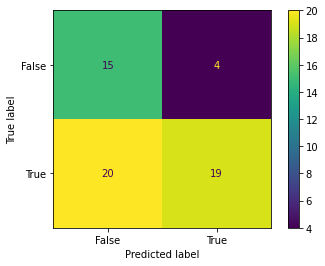

In [18]:
# generate preductions and confusion matrix for train set
cm = confusion_matrix(excluded_drugs['RG_binary'], excluded_out['Prediction'], labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

# Applying model to example analogs of emetine

In [19]:
emetine_analogs = pd.read_csv('Data_files/descriptors_emetine_analogs.csv')
emetine_analogs

,SMILES,CASRN,EXTERNALID,N,NAME,ARTICLEID,PUBMEDID,PAGE,TABLE,ERROR,...,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment
0,CC[C@H]1CN2CCC3=CC(OC)=C(OC)C=C3C2C[C@@H]1C[C@...,-,-,-,Emetine,-,-,-,-,-,...,0,0.0,6.0,7.5,30.25,0.8643,5.375,0.15360,29.98,5.169
1,CC[C@H]1CN2CCC3=CC(OC)=C(OC)C=C3C2C[C@@H]1C[C@...,-,-,-,Emetine-A1,-,-,-,-,-,...,0,0.0,6.0,7.5,31.00,0.8611,5.375,0.14930,30.84,5.169
2,CC[C@H]1CN2CCC3=CC(OC)=C(OC)C=C3C2C[C@@H]1C[C@...,-,-,-,Emetine-A2,-,-,-,-,-,...,0,0.0,6.0,7.5,31.75,0.8581,5.375,0.14530,31.76,5.169
3,CCCN1CCC2=CC(OC)=C(OC)C=C2[C@H]1C[C@H]1CC2N(CC...,-,-,-,Emetine-A3,-,-,-,-,-,...,0,0.0,6.0,7.5,32.50,0.8553,5.375,0.14150,32.72,5.169
4,CCCCN1CCC2=CC(OC)=C(OC)C=C2[C@H]1C[C@H]1CC2N(C...,-,-,-,Emetine-A4,-,-,-,-,-,...,0,0.0,6.0,7.5,33.25,0.8526,5.375,0.13780,33.72,5.169
5,CCCCCN1CCC2=CC(OC)=C(OC)C=C2[C@H]1C[C@H]1CC2N(...,-,-,-,Emetine-A5,-,-,-,-,-,...,0,0.0,6.0,7.5,34.00,0.8500,5.375,0.13440,34.76,5.169
6,CCCCCCN1CCC2=CC(OC)=C(OC)C=C2[C@H]1C[C@H]1CC2N...,-,-,-,Emetine-A6,-,-,-,-,-,...,0,0.0,6.0,7.5,34.75,0.8476,5.375,0.13110,35.85,5.169
7,CCCCCCCN1CCC2=CC(OC)=C(OC)C=C2[C@H]1C[C@H]1CC2...,-,-,-,Emetine-A7,-,-,-,-,-,...,0,0.0,6.0,7.5,35.50,0.8452,5.375,0.12800,36.97,5.169
8,CCCCCCCCN1CCC2=CC(OC)=C(OC)C=C2[C@H]1C[C@H]1CC...,-,-,-,Emetine-A8,-,-,-,-,-,...,0,0.0,6.0,7.5,36.25,0.8430,5.375,0.12500,38.13,5.169
9,CCCCCCCCCN1CCC2=CC(OC)=C(OC)C=C2[C@H]1C[C@H]1C...,-,-,-,Emetine-A9,-,-,-,-,-,...,0,1.5,4.5,7.5,37.25,0.8466,5.125,0.11650,39.32,5.169


In [20]:
#pd.set_option('display.max_colwidth', 1000)
emetine_analogs_out = emetine_analogs.apply(lambda x: predict_siRNA_complexation(x,x['NAME']),axis=1)
emetine_analogs_out

,Name,Prediction,Comment
0,Emetine,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...
1,Emetine-A1,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...
2,Emetine-A2,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...
3,Emetine-A3,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...
4,Emetine-A4,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...
5,Emetine-A5,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...
6,Emetine-A6,False,ALOGP < 8.0 & nAB <= 12 - Predicted NOT to com...
7,Emetine-A7,True,ALOGP > 8.0 - Predicted to complex siRNA
8,Emetine-A8,True,ALOGP > 8.0 - Predicted to complex siRNA
9,Emetine-A9,True,ALOGP > 8.0 - Predicted to complex siRNA


In [21]:
# Examining additional parameters relevant for encapsulation and size of IDNPs
emetine_analogs[['NAME','CMC-80','ALOGP','AMR','nAB','ChiralCenter','nHDon','JGI7','J_G']]

,NAME,CMC-80,ALOGP,AMR,nAB,ChiralCenter,nHDon,JGI7,J_G
0,Emetine,0,4.945,139.7,12,4,1,0.01481,2.194
1,Emetine-A1,0,5.481,145.0,12,4,0,0.01566,2.231
2,Emetine-A2,0,5.830,149.8,12,4,0,0.01611,2.303
3,Emetine-A3,0,6.354,154.3,12,4,0,0.01536,2.394
4,Emetine-A4,0,6.810,158.9,12,4,0,0.01509,2.457
5,Emetine-A5,0,7.266,163.5,12,4,0,0.01467,2.456
6,Emetine-A6,0,7.722,168.1,12,4,0,0.01427,2.474
7,Emetine-A7,0,8.179,172.7,12,4,0,0.01408,2.504
8,Emetine-A8,0,8.635,177.3,12,4,0,0.01389,2.438
9,Emetine-A9,0,9.091,181.9,12,4,0,0.01371,2.535
